In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [68]:
df = pd.read_csv("conspiracy_theories_data_orig.csv")

# Only NaN values are in "major" column, so no other cleaning is necessary
# Benefit of working with survey data as opposed to data collected using messier methods
# TODO: check for survey responses that don't make sense (answered just the default answer for all 
# questions); these should be thrown out

In [69]:
# Measure for General Conspiracy Belief. Normalized average of responses to questions 1-15 of survey
df['GCB'] = df[['Q'+str(i) for i in range(1, 16)]].mean(axis=1) / 5

In [70]:
# The survey asked participants what words they knew. Columns VCL6, VCL9, VCL12 were not real words, and were included in 
# order to perform a validity check

df['validity'] = df[['VCL6', 'VCL9', 'VCL12']].mean(axis=1)
df['vocabulary_knowledge'] = df[['VCL' + str(i) for i in [1, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15, 16]]].mean(axis=1)

### Categorizing Majors

In [71]:
#I split up every instance of "major" to a category: HUM (Humanities), BUS (business/law), ART, STEM, and OTHER. 
#This block creates a one-hot encoding for each of these.
names = ["STEM", "HUM", "BUS", "OTHER", "ART"]
for name in names:
    tf = open(f"{name}.txt", "r",newline='\n')
    majors = [i[:-2] for i in tf.readlines()]
    def func(x):
        return int(x in majors)
    func = np.vectorize(func)
    df[name] = 1
    df[name] = df.major.apply(func)
#next, I go through to find closest edit distances between observations that aren't in the lists and elements of the lists.
#we assign the observation to the group is is most closely related to.

#### Defining Edit Distance (from internet)

In [72]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [106]:
#select unassigned
unassigned = df[df["STEM"]+df["HUM"]+df["BUS"]+df["OTHER"]+df["ART"] == 0]
categories = ["STEM", "HUM", "BUS", "OTHER", "ART"]
score = dict()
for index,unknown_string in zip(unassigned.index,unassigned['major']):
    for category in categories:
        tf = open(f"{category}.txt", "r",newline='\n')
        majors = [i[:-2] for i in tf.readlines()]
        score[category] = min([levenshteinDistance(str(maj),str(unknown_string)) for maj in majors])
    min_key = min(score, key=score.get)
    df.loc[index,min_key] = 1

### Creating Age, Vocab, GCB Heatmap

Text(0.5, 1.0, 'General Conspiracy Belief')

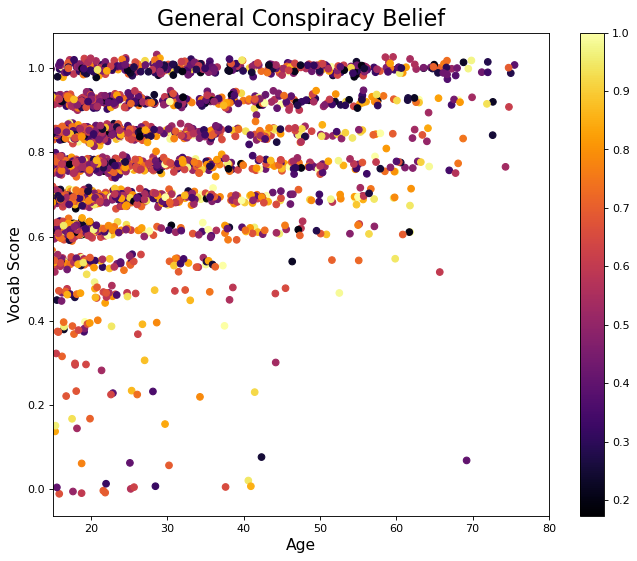

In [105]:
plt.figure(figsize=(10, 8), dpi=80)
noise = np.random.normal(0, .5, df['age'].shape)
perturbed_age = df['age'] + noise
noise2 = np.random.normal(0, .01, df['vocabulary_knowledge'].shape)
perturbed_vocab = df['vocabulary_knowledge'] + noise2
plt.scatter(perturbed_age, perturbed_vocab, s=35, c=df['GCB'], cmap='inferno')
plt.colorbar()
plt.ylabel('Vocab Score',fontsize=14)
plt.xlabel('Age',fontsize=14)
plt.xlim(15,80)
plt.title('General Conspiracy Belief',fontsize=20)